<a href="https://colab.research.google.com/github/baynk/hello-world/blob/master/Paper_Trading_(Colab)v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import numpy as np              # For numerical computations
import pandas as pd             # For data manipulation and analysis
import scipy.stats as stats     # For statistical tests
import statsmodels.api as sm    # For additional statistical tests
import matplotlib.pyplot as plt # For visualization
import seaborn as sns           # For enhanced visualizations
import yfinance as yf           # For fetching financial data

# Set plotting style
plt.style.use('dark_background')  # Use a dark background for better contrast
sns.set_palette("husl")           # Set a color palette for consistency across plots

# Configure pandas display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Define metric guidelines for evaluating trader performance
METRIC_GUIDELINES = {
    'sharpe_ratio': {
        'excellent': 2.0,
        'good': 1.5,
        'acceptable': 1.0,
        'poor': 0.5,
        'description': 'Risk-adjusted returns using total volatility'
    },
    'sortino_ratio': {
        'excellent': 2.5,
        'good': 2.0,
        'acceptable': 1.5,
        'poor': 1.0,
        'description': 'Risk-adjusted returns using downside volatility'
    },
    'k_ratio': {
        'excellent': 1.0,
        'good': 0.7,
        'acceptable': 0.5,
        'poor': 0.3,
        'description': 'Trend consistency relative to volatility'
    },
    'max_drawdown': {
        'excellent': -0.10,
        'good': -0.15,
        'acceptable': -0.20,
        'poor': -0.25,
        'description': 'Worst peak to trough decline'
    },
    'win_rate': {
        'excellent': 0.60,
        'good': 0.55,
        'acceptable': 0.52,
        'poor': 0.48,
        'description': 'Percentage of profitable trades'
    },
    'profit_factor': {
        'excellent': 2.0,
        'good': 1.75,
        'acceptable': 1.5,
        'poor': 1.25,
        'description': 'Ratio of gross profits to gross losses'
    },
    'monte_carlo_percentile': {
        'excellent': 90,
        'good': 80,
        'acceptable': 70,
        'poor': 50,
        'description': 'Performance ranking via simulation'
    }
}


# Part 2: Data Generation Functions
## 2.1 Generate GBM Returns Function

Generates log returns following a Geometric Brownian Motion, simulating realistic price movements.

Allows setting the number of days, expected return, volatility, initial price, and random seed for reproducibility.

In [2]:
def generate_gbm_returns(n_days=252, mu=0.05, sigma=0.15, S0=100, seed=None):
    """
    Generate returns using Geometric Brownian Motion (GBM)

    Parameters:
    -----------
    n_days: int
        Number of trading days
    mu: float
        Expected annual return (drift)
    sigma: float
        Annual volatility
    S0: float
        Initial price
    seed: int or None
        Random seed for reproducibility
    """
    if seed is not None:
        np.random.seed(seed)
    dt = 1 / 252  # Daily time step
    prices = [S0]
    for _ in range(n_days):
        random_shock = np.random.normal(loc=(mu - 0.5 * sigma ** 2) * dt, scale=sigma * np.sqrt(dt))
        price = prices[-1] * np.exp(random_shock)
        prices.append(price)
    returns = pd.Series(np.diff(np.log(prices)))
    return returns

## 2.2 Generate Trader Data

* Trader Profiles: Each trader is simulated with different mu and sigma values to represent different trading styles.
* Random Seeds: Ensures reproducibility of the results for each trader.

In [3]:
def generate_trader_data(n_traders=4, n_days=252):
    """
    Generate different trader types with varying skill levels
    """
    traders_data = {}

    # Trader 1: Skilled systematic trader
    traders_data['Trader_1'] = generate_gbm_returns(n_days, mu=0.15, sigma=0.12, seed=101)

    # Trader 2: Aggressive discretionary trader
    traders_data['Trader_2'] = generate_gbm_returns(n_days, mu=0.20, sigma=0.25, seed=102)

    # Trader 3: Conservative trader
    traders_data['Trader_3'] = generate_gbm_returns(n_days, mu=0.08, sigma=0.08, seed=103)

    # Trader 4: Random trader (market returns with noise)
    traders_data['Trader_4'] = generate_gbm_returns(n_days, mu=0.05, sigma=0.15, seed=104)

    return pd.DataFrame(traders_data)


# Part 3: Fetching Real Financial Data

* **Real Data:** Using actual ETF tickers to represent trader returns.
* **Tickers:**
 * UPGD: Represents Trader 1
 * GURU: Represents Trader 2
 * MOAT: Represents Trader 3
 * EQAL: Used as the Benchmark

**Log Returns:** Calculated to ensure returns are additive over time.

In [4]:
# Fetching financial data for Traders 1-3 and Benchmark
tickers = ['UPGD', 'GURU', 'MOAT', 'EQAL']
prices = yf.download(tickers)['Adj Close']

# Calculating log returns
returns = np.log(prices / prices.shift(1)).dropna()
returns.rename(columns={'UPGD': 'Trader_1', 'GURU': 'Trader_2', 'MOAT': 'Trader_3', 'EQAL': 'Benchmark'}, inplace=True)


[*********************100%***********************]  4 of 4 completed


# Adding Trader 4 (GBM Simulated Trader)

* Ensures that Trader 4 has the same number of observations as the other traders.
* Trader 4 is set with a lower expected return and volatility to simulate a random trader.


In [5]:
# Generate Trader 4 returns using GBM
n_days = len(returns)
returns['Trader_4'] = generate_gbm_returns(n_days=n_days, mu=0.05, sigma=0.10, seed=105).values
returns.dropna(inplace=True)

# Part 4: Exploratory Data Analysis (EDA)
## 4.1 Summary Statistics

In [6]:
# Summary statistics
print("Summary Statistics:")
display(returns.describe().T)

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
Benchmark,2481.00000,0.00033,0.01190,-0.11954,-0.00505,0.00081,0.00637,0.10856
Trader_2,2481.00000,0.00027,0.01262,-0.13080,-0.00524,0.00088,0.00674,0.08829
Trader_3,2481.00000,0.00050,0.01174,-0.10278,-0.00472,0.00070,0.00630,0.09014
Trader_1,2481.00000,0.00031,0.01394,-0.15200,-0.00638,0.00091,0.00762,0.10012
Trader_4,2481.00000,0.00002,0.00627,-0.01958,-0.00412,0.00001,0.00434,0.01817


## 4.2 Cumulative Returns Plot

* **Cumulative Returns:** Converts log returns back to cumulative returns for visualization.
* **Plot:** Shows the performance of each trader over time compared to the benchmark.

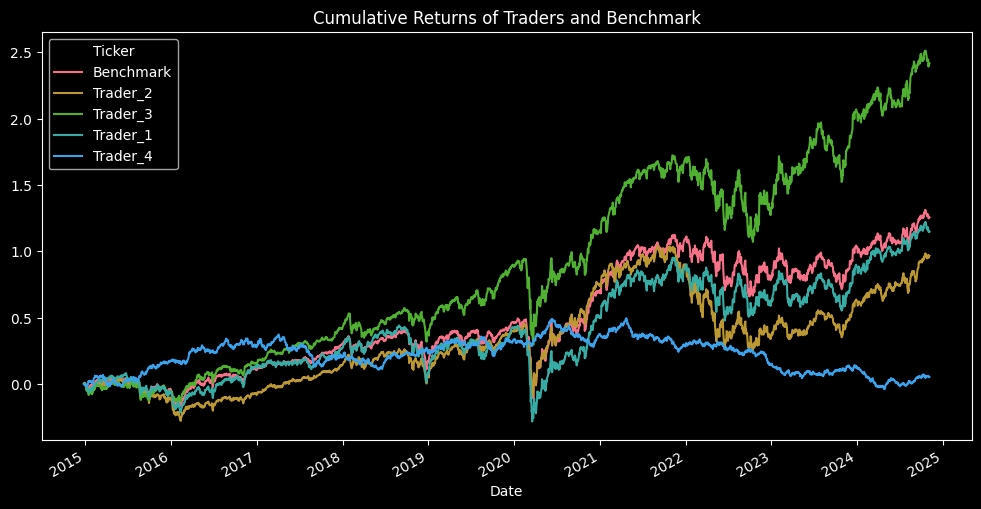

In [7]:
# Cumulative returns
cumulative_returns = np.exp(returns.cumsum()) - 1
cumulative_returns.plot(figsize=(12, 6), title='Cumulative Returns of Traders and Benchmark')
plt.show()

# Part 5: Calculating Performance Metrics
## 5.1 Comprehensive Metrics Calculation Function

* Incorporated additional statistical tests from your Carlos's code, such as the Jarque-Bera test, Shapiro-Wilk test, D'Agostino's K-squared test, and the  Augmented Dickey-Fuller test for stationarity.
* Calculates a comprehensive set of metrics for each trader.

In [8]:
def calculate_all_metrics(returns_df):
    """
    Calculate a comprehensive suite of trading metrics for all traders.
    """
    metrics_dict = {}

    for trader in returns_df.columns:
        try:
            returns = returns_df[trader]

            # Basic Statistics
            mean_ret = returns.mean() * 252  # Annualized mean return
            std_ret = returns.std() * np.sqrt(252)  # Annualized volatility
            skew = stats.skew(returns)
            kurt = stats.kurtosis(returns, fisher=False)

            # Risk Metrics with error handling
            sharpe = mean_ret / std_ret if std_ret != 0 else 0
            downside_returns = returns[returns < 0]
            downside_std = downside_returns.std() * np.sqrt(252)
            sortino = mean_ret / downside_std if downside_std != 0 else 0

            # K-Ratio Calculation
            cum_returns = (1 + returns).cumprod()
            x = np.arange(len(cum_returns))
            slope, _, _, _, _ = stats.linregress(x, cum_returns)
            rolling_slopes = []
            window_size = 20
            for i in range(len(returns) - window_size):
                window = cum_returns[i:i+window_size]
                window_x = np.arange(window_size)
                window_slope, _, _, _, _ = stats.linregress(window_x, window)
                rolling_slopes.append(window_slope)
            k_ratio = slope / np.std(rolling_slopes) if len(rolling_slopes) > 0 else 0

            # Drawdown Analysis
            equity_curve = (1 + returns).cumprod()
            rolling_max = equity_curve.expanding(min_periods=1).max()
            drawdowns = equity_curve / rolling_max - 1
            max_drawdown = drawdowns.min()
            total_return = equity_curve.iloc[-1] - 1

            # Win Rate and Profit Metrics
            wins = returns[returns > 0]
            losses = returns[returns < 0]
            win_rate = len(wins) / len(returns) if len(returns) > 0 else 0
            profit_factor = abs(wins.sum() / losses.sum()) if len(losses) > 0 else float('inf')
            gain_to_pain = abs(wins.mean() / losses.mean()) if len(losses) > 0 and losses.mean() != 0 else float('inf')

            # Recovery Factor
            recovery_factor = abs(total_return / max_drawdown) if max_drawdown != 0 and not np.isnan(max_drawdown) else float('inf')

            # Statistical Tests
            t_stat, p_value = stats.ttest_1samp(returns, 0, alternative='greater')

            # Additional Tests (from advisor's code)
            # Normality Tests
            jb_stat, jb_pvalue = stats.jarque_bera(returns)
            sw_stat, sw_pvalue = stats.shapiro(returns)
            da_stat, da_pvalue = stats.normaltest(returns)

            # Stationarity Test
            adf_result = sm.tsa.stattools.adfuller(returns)
            adf_stat = adf_result[0]
            adf_pvalue = adf_result[1]

            metrics_dict[trader] = {
                'mean_return': mean_ret,
                'volatility': std_ret,
                'skewness': skew,
                'kurtosis': kurt,
                'sharpe_ratio': sharpe,
                'sortino_ratio': sortino,
                'k_ratio': k_ratio,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate,
                'profit_factor': profit_factor,
                'gain_to_pain': gain_to_pain,
                'recovery_factor': recovery_factor,
                't_statistic': t_stat,
                'p_value': p_value,
                'jb_pvalue': jb_pvalue,
                'sw_pvalue': sw_pvalue,
                'da_pvalue': da_pvalue,
                'adf_pvalue': adf_pvalue
            }
        except Exception as e:
            print(f"Error calculating metrics for {trader}: {str(e)}")
            metrics_dict[trader] = {metric: np.nan for metric in ['mean_return', 'volatility', 'skewness',
                                                                  'kurtosis', 'sharpe_ratio', 'sortino_ratio',
                                                                  'k_ratio', 'max_drawdown', 'win_rate',
                                                                  'profit_factor', 'gain_to_pain',
                                                                  'recovery_factor', 't_statistic', 'p_value',
                                                                  'jb_pvalue', 'sw_pvalue', 'da_pvalue', 'adf_pvalue']}

    return pd.DataFrame(metrics_dict)

## 5.2 Calculate Metrics

In [9]:
# Calculate metrics
metrics_df = calculate_all_metrics(returns)
print("Performance Metrics:")
display(metrics_df.round(4))

Performance Metrics:


,Benchmark,Trader_2,Trader_3,Trader_1,Trader_4
mean_return,0.08250,0.06870,0.12480,0.07770,0.00540
volatility,0.18900,0.20040,0.18630,0.22130,0.09950
skewness,-0.77930,-0.81680,-0.52780,-1.27470,-0.09460
kurtosis,17.08150,13.49560,13.72540,19.48270,2.84700
sharpe_ratio,0.43680,0.34290,0.66980,0.35090,0.05400
sortino_ratio,0.53230,0.41830,0.83580,0.42260,0.08750
k_ratio,0.09350,0.06650,0.15890,0.05630,-0.01760
max_drawdown,-0.42450,-0.41200,-0.35250,-0.53690,-0.36650
win_rate,0.53200,0.53650,0.53890,0.53000,0.50100
profit_factor,1.08520,1.06520,1.13330,1.06700,1.00850


# Part 6: Statistical Tests
## 6.1 Normality Tests Function

In [10]:
def normality_tests(returns_df):
    """
    Perform normality tests on returns.
    """
    results = {}
    for trader in returns_df.columns:
        returns = returns_df[trader]
        jb_stat, jb_pvalue = stats.jarque_bera(returns)
        sw_stat, sw_pvalue = stats.shapiro(returns)
        da_stat, da_pvalue = stats.normaltest(returns)
        results[trader] = {
            'JB_pvalue': jb_pvalue,
            'SW_pvalue': sw_pvalue,
            'DA_pvalue': da_pvalue
        }
    return pd.DataFrame(results)


## 6.2 Stationarity Test Function

In [14]:
def stationarity_test(returns_df):
    """
    Perform stationarity test on returns using Augmented Dickey-Fuller test.
    """
    results = {}
    for trader in returns_df.columns:
        returns = returns_df[trader]
        adf_result = sm.tsa.stattools.adfuller(returns)
        adf_pvalue = adf_result[1]
        results[trader] = {
            'ADF_pvalue': adf_pvalue
        }
    return pd.DataFrame(results)


## 6.3 Perform Tests

* Normality Tests: Evaluates whether the returns of each trader follow a normal distribution.
* Stationarity Test: Checks if the returns are stationary.

In [13]:
# Normality Tests
normality_results = normality_tests(returns)
print("Normality Test p-values:")
display(normality_results)

# Stationarity Tests
stationarity_results = stationarity_test(returns)
print("Stationarity Test p-values:")
display(stationarity_results)


Normality Test p-values:


,Benchmark,Trader_2,Trader_3,Trader_1,Trader_4
JB_pvalue,0.00000,0.00000,0.00000,0.00000,0.04684
SW_pvalue,0.00000,0.00000,0.00000,0.00000,0.03195
DA_pvalue,0.00000,0.00000,0.00000,0.00000,0.04224


Stationarity Test p-values:


,Benchmark,Trader_2,Trader_3,Trader_1,Trader_4
ADF_pvalue,0.00000,0.00000,0.00000,0.00000,0.00000


# Part 7: T-Statistic Tests

* Determines whether the trader's mean return is significantly greater than zero, indicating skill rather than luck.

* A p-value less than 0.05 suggests that we can reject the null hypothesis of zero mean return.

In [15]:
# One-sample t-test to check if mean returns are significantly greater than zero
print("One-sample t-test results:")
for trader in returns.columns:
    t_stat, p_value = stats.ttest_1samp(returns[trader], popmean=0, alternative='greater')
    print(f"{trader}: T-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")


One-sample t-test results:
Benchmark: T-statistic = 1.3706, p-value = 0.0853
Trader_2: T-statistic = 1.0758, p-value = 0.1411
Trader_3: T-statistic = 2.1017, p-value = 0.0178
Trader_1: T-statistic = 1.1012, p-value = 0.1355
Trader_4: T-statistic = 0.1694, p-value = 0.4328


# Part 8: Evaluation Function


In [16]:
def evaluate_trader(trader_metrics):
    """
    Evaluate trader performance metrics against predefined guidelines.
    """
    evaluation = {}
    for metric, guidelines in METRIC_GUIDELINES.items():
        value = trader_metrics.get(metric, None)
        if value is not None:
            if metric == 'max_drawdown':  # For drawdowns, less negative is better
                if value >= guidelines['excellent']:
                    rating = 'Excellent'
                elif value >= guidelines['good']:
                    rating = 'Good'
                elif value >= guidelines['acceptable']:
                    rating = 'Acceptable'
                else:
                    rating = 'Poor'
            else:  # For other metrics, higher is better
                if value >= guidelines['excellent']:
                    rating = 'Excellent'
                elif value >= guidelines['good']:
                    rating = 'Good'
                elif value >= guidelines['acceptable']:
                    rating = 'Acceptable'
                else:
                    rating = 'Poor'
            evaluation[metric] = rating
    return evaluation


## 8.1 Evaluate All Traders

Rates each trader's performance metrics against predefined thresholds, providing a qualitative assessment.

Displays ratings for each metric per trader, helping identify areas of strength and weakness.

In [17]:
# Evaluate each trader
evaluations = {}
for trader in metrics_df.columns:
    trader_metrics = metrics_df[trader]
    evaluation = evaluate_trader(trader_metrics)
    evaluations[trader] = evaluation

# Display evaluations
print("Trader Evaluations:")
for trader, evals in evaluations.items():
    print(f"\n{trader}:")
    for metric, rating in evals.items():
        print(f"  {metric}: {rating}")


Trader Evaluations:

Benchmark:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor

Trader_2:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor

Trader_3:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor

Trader_1:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor

Trader_4:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Poor
  profit_factor: Poor


# Part 9: Monte Carlo Simulation Function
## 9.1 Monte Carlo Simulation Function

Purpose: Assesses the robustness of the trader's Sharpe Ratio by comparing it against a distribution of simulated Sharpe Ratios.

**Process:**

* Bootstrap Sampling: Generates n_sims simulated return series by resampling the trader's returns with replacement.
* Metric Calculation: Computes the Sharpe Ratio for each simulated series.
* Percentile Ranking: Determines where the trader's actual Sharpe Ratio stands relative to the simulated distribution.
* Interpretation: A higher percentile suggests that the trader's performance is less likely due to chance.


In [18]:
def monte_carlo_simulation(returns, n_sims=1000):
    """
    Perform Monte Carlo simulation to evaluate the statistical significance of a trader's performance.
    """
    try:
        # Calculate original Sharpe Ratio
        original_sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
        simulated_sharpes = []

        for _ in range(n_sims):
            # Bootstrap sample with replacement
            sim_returns = np.random.choice(returns, size=len(returns), replace=True)
            sim_sharpe = (np.mean(sim_returns) / np.std(sim_returns)) * np.sqrt(252)
            simulated_sharpes.append(sim_sharpe)

        # Calculate percentile ranking
        percentile = stats.percentileofscore(simulated_sharpes, original_sharpe)

        # Additional statistics
        sim_mean = np.mean(simulated_sharpes)
        sim_std = np.std(simulated_sharpes)

        return {
            'original_sharpe': original_sharpe,
            'percentile': percentile,
            'sim_mean': sim_mean,
            'sim_std': sim_std
        }
    except Exception as e:
        print(f"Error in Monte Carlo simulation: {str(e)}")
        return None


## 9.2 Perform Monte Carlo Simulations for All Traders

* Performs the simulation for each trader's return series.
* Results: Prints out the original Sharpe Ratio, the percentile ranking, and statistics of the simulated Sharpe Ratios.

In [19]:
# Perform Monte Carlo simulations
monte_carlo_results = {}
for trader in returns.columns:
    mc_result = monte_carlo_simulation(returns[trader])
    monte_carlo_results[trader] = mc_result

# Display Monte Carlo results
print("Monte Carlo Simulation Results:")
for trader, result in monte_carlo_results.items():
    print(f"\n{trader}:")
    print(f"  Original Sharpe Ratio: {result['original_sharpe']:.4f}")
    print(f"  Percentile Ranking: {result['percentile']:.2f}%")
    print(f"  Simulated Sharpe Mean: {result['sim_mean']:.4f}")
    print(f"  Simulated Sharpe Std Dev: {result['sim_std']:.4f}")


Monte Carlo Simulation Results:

Benchmark:
  Original Sharpe Ratio: 0.4368
  Percentile Ranking: 50.80%
  Simulated Sharpe Mean: 0.4305
  Simulated Sharpe Std Dev: 0.3184

Trader_2:
  Original Sharpe Ratio: 0.3429
  Percentile Ranking: 52.80%
  Simulated Sharpe Mean: 0.3211
  Simulated Sharpe Std Dev: 0.3227

Trader_3:
  Original Sharpe Ratio: 0.6698
  Percentile Ranking: 48.90%
  Simulated Sharpe Mean: 0.6770
  Simulated Sharpe Std Dev: 0.3272

Trader_1:
  Original Sharpe Ratio: 0.3509
  Percentile Ranking: 50.30%
  Simulated Sharpe Mean: 0.3520
  Simulated Sharpe Std Dev: 0.3330

Trader_4:
  Original Sharpe Ratio: 0.0540
  Percentile Ranking: 47.40%
  Simulated Sharpe Mean: 0.0743
  Simulated Sharpe Std Dev: 0.3168


# Part 10: Visualization
## 10.1 Enhanced Visualization Function

**Visualization Enhancements:**



1.   Equity Curves: Includes total return percentages in the legend.
2.   Risk-Return Scatter: Uses bubble sizes proportional to the Sharpe Ratio magnitude.
3. Heatmaps and Bar Charts: Visual representation of key metrics and Monte Carlo percentiles.
4. Drawdown Analysis: Visualizes drawdowns over time, indicating maximum drawdown.
5. Rolling Sharpe Ratio: Shows how the Sharpe Ratio changes over time, providing insight into consistency.


In [20]:
def plot_comprehensive_analysis(returns_df, metrics_df, monte_carlo_results):
    """
    Create an enhanced visualization dashboard with advanced plots and better formatting.
    """
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(20, 15))

    # Create a grid specification
    gs = fig.add_gridspec(4, 3)

    # 1. Enhanced Equity Curves with Total Returns
    ax1 = fig.add_subplot(gs[0, :2])
    equity_curves = np.exp(returns_df.cumsum()) - 1
    for trader in equity_curves.columns:
        total_return = equity_curves[trader].iloc[-1] * 100
        ax1.plot(equity_curves.index, equity_curves[trader],
                 label=f"{trader} (Total Return: {total_return:.1f}%)")
    ax1.set_title('Equity Curves with Total Returns', fontsize=12, pad=20)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.2)

    # 2. Enhanced Risk-Return Scatter with Sharpe Ratio Bubbles
    ax2 = fig.add_subplot(gs[0, 2])
    sizes = np.abs(metrics_df.loc['sharpe_ratio']) * 100
    scatter = ax2.scatter(metrics_df.loc['volatility'],
                          metrics_df.loc['mean_return'],
                          s=sizes,
                          c=metrics_df.loc['sharpe_ratio'],
                          cmap='RdYlGn',
                          alpha=0.6)
    plt.colorbar(scatter, ax=ax2, label='Sharpe Ratio')
    for trader in metrics_df.columns:
        ax2.annotate(f"{trader}\nSR: {metrics_df.loc['sharpe_ratio', trader]:.2f}",
                     (metrics_df.loc['volatility', trader],
                      metrics_df.loc['mean_return', trader]),
                     xytext=(10, 10), textcoords='offset points')
    ax2.set_title('Risk-Return Analysis\nBubble Size = |Sharpe Ratio|', fontsize=12)
    ax2.set_xlabel('Volatility (annualized)')
    ax2.set_ylabel('Mean Return (annualized)')
    ax2.grid(True, alpha=0.2)

    # 3. Enhanced Performance Metrics Heatmap
    ax3 = fig.add_subplot(gs[1, :2])
    key_metrics = metrics_df.loc[['sharpe_ratio', 'sortino_ratio', 'k_ratio',
                                  'max_drawdown', 'win_rate', 'profit_factor']]
    sns.heatmap(key_metrics, annot=True, cmap='RdYlGn', center=0, ax=ax3,
                fmt='.2f', cbar_kws={'label': 'Normalized Metric Value'})
    ax3.set_title('Key Performance Metrics Heatmap', fontsize=12)

    # 4. Enhanced Monte Carlo Percentiles with Confidence Intervals
    ax4 = fig.add_subplot(gs[1, 2])
    percentiles = pd.Series({trader: monte_carlo_results[trader]['percentile'] for trader in returns_df.columns})
    percentiles.plot(kind='bar', ax=ax4, width=0.8, color='skyblue')
    ax4.axhline(y=80, color='g', linestyle='--', label='80th Percentile')
    ax4.axhline(y=50, color='y', linestyle='--', label='Median')
    ax4.set_title('Monte Carlo Simulation Results', fontsize=12)
    ax4.set_ylabel('Percentile Ranking')
    ax4.legend()
    ax4.grid(True, alpha=0.2)

    # 5. Enhanced Statistical Significance with Effect Size
    ax5 = fig.add_subplot(gs[2, 0])
    significance = -np.log10(metrics_df.loc['p_value'])
    significance.plot(kind='bar', ax=ax5, color='orange')
    ax5.axhline(y=-np.log10(0.05), color='r', linestyle='--',
                label='5% Significance Level')
    ax5.set_title('Statistical Significance\n(-log10 p-value)', fontsize=12)
    ax5.set_ylabel('-log10(p-value)')
    ax5.legend()
    ax5.grid(True, alpha=0.2)

    # 6. Enhanced Drawdown Analysis
    ax6 = fig.add_subplot(gs[2, 1:])
    drawdowns = returns_df.apply(
        lambda x: (1 + x).cumprod() / (1 + x).cumprod().expanding().max() - 1)
    for trader in drawdowns.columns:
        max_dd = drawdowns[trader].min() * 100
        ax6.plot(drawdowns.index, drawdowns[trader],
                 label=f"{trader} (Max DD: {max_dd:.1f}%)")
    ax6.set_title('Drawdown Analysis', fontsize=12)
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax6.grid(True, alpha=0.2)

    # 7. Rolling Sharpe Ratio
    ax7 = fig.add_subplot(gs[3, :])
    window = 20
    rolling_sharpes = pd.DataFrame()
    for trader in returns_df.columns:
        roll = returns_df[trader].rolling(window)
        rolling_sharpe = np.sqrt(252) * (roll.mean() / roll.std())
        rolling_sharpes[trader] = rolling_sharpe
    rolling_sharpes.plot(ax=ax7)
    ax7.set_title(f'Rolling {window}-Day Sharpe Ratio', fontsize=12)
    ax7.grid(True, alpha=0.2)

    plt.tight_layout()
    return fig


## 10.2 Generate and Display Visualizations


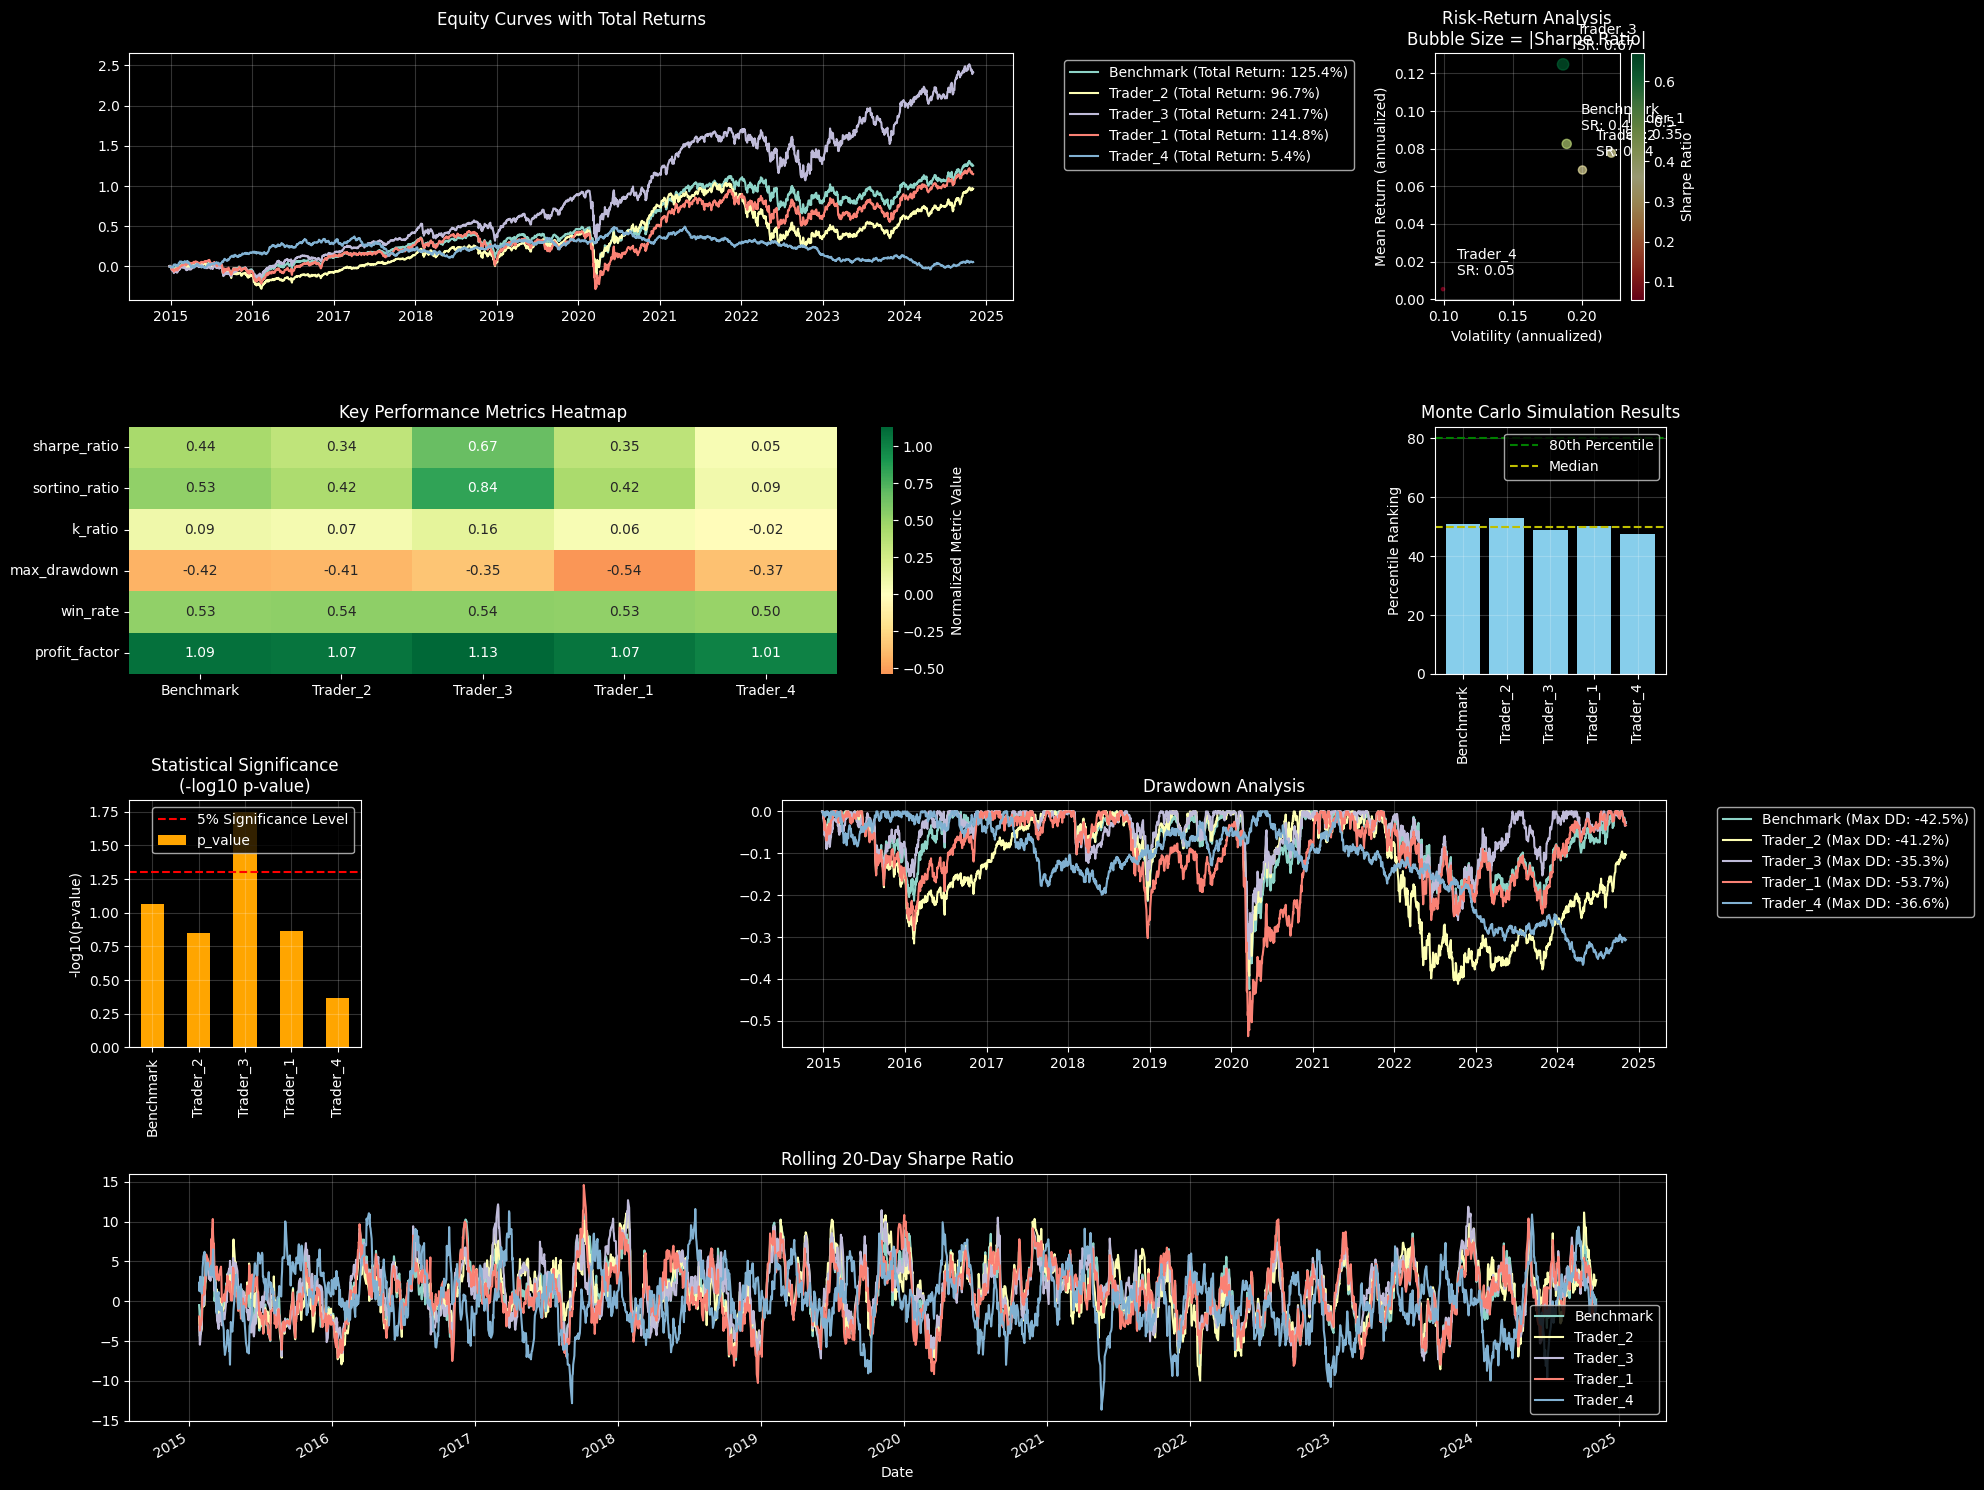

In [21]:
# Generate the visualization
fig = plot_comprehensive_analysis(returns, metrics_df, monte_carlo_results)

# Display the plots
plt.show()

# Part 11: Comprehensive Report Creation
## 11.1 Create Comprehensive Report Function

Combines metrics calculation, Monte Carlo simulations, evaluations, rankings, and visualization into one report.

Adds the Monte Carlo percentile to the metrics DataFrame for easier reference.

Returns a dictionary containing all components of the report.



In [22]:
def create_comprehensive_report(returns_df):
    """
    Generate a comprehensive trading evaluation report.
    """
    # Calculate metrics
    metrics = calculate_all_metrics(returns_df)

    # Perform Monte Carlo simulations
    monte_carlo_results = {}
    for trader in returns_df.columns:
        mc_result = monte_carlo_simulation(returns_df[trader])
        monte_carlo_results[trader] = mc_result
        # Add Monte Carlo percentile to metrics
        metrics.loc['monte_carlo_percentile', trader] = mc_result['percentile']

    # Evaluate traders
    evaluations = {}
    for trader in metrics.columns:
        trader_metrics = metrics[trader]
        evaluation = evaluate_trader(trader_metrics)
        evaluations[trader] = evaluation

    # Calculate rankings
    rankings = calculate_overall_rankings(metrics)

    # Generate visualization
    fig = plot_comprehensive_analysis(returns_df, metrics, monte_carlo_results)

    # Compile report
    report = {
        'metrics': metrics,
        'monte_carlo': monte_carlo_results,
        'evaluations': evaluations,
        'rankings': rankings,
        'visualization': fig
    }

    return report


## 11.2 Calculate Overall Rankings Function

Purpose: Assigns rankings to each trader based on key performance metrics.

Ranking Logic: For most metrics, higher values are better; for max drawdown, lower (less negative) values are better.

Overall Ranking: Averages the rankings to get an overall score.



In [23]:
def calculate_overall_rankings(metrics_df):
    """
    Calculate overall rankings based on multiple metrics.
    """
    try:
        # Select key metrics for ranking
        ranking_metrics = ['sharpe_ratio', 'sortino_ratio', 'k_ratio',
                           'win_rate', 'profit_factor', 'max_drawdown']

        # Create ranking dataframe
        rankings = pd.DataFrame(index=metrics_df.columns)

        # Calculate rankings for each metric
        for metric in ranking_metrics:
            if metric == 'max_drawdown':
                rankings[metric] = metrics_df.loc[metric].rank(ascending=True)
            else:
                rankings[metric] = metrics_df.loc[metric].rank(ascending=False)

        # Calculate overall ranking
        rankings['overall'] = rankings.mean(axis=1)
        rankings = rankings.sort_values('overall')

        return rankings
    except Exception as e:
        print(f"Error in ranking calculation: {str(e)}")
        return None


# Part 12: Main Execution
## 12.1 Generate Data and Create Report

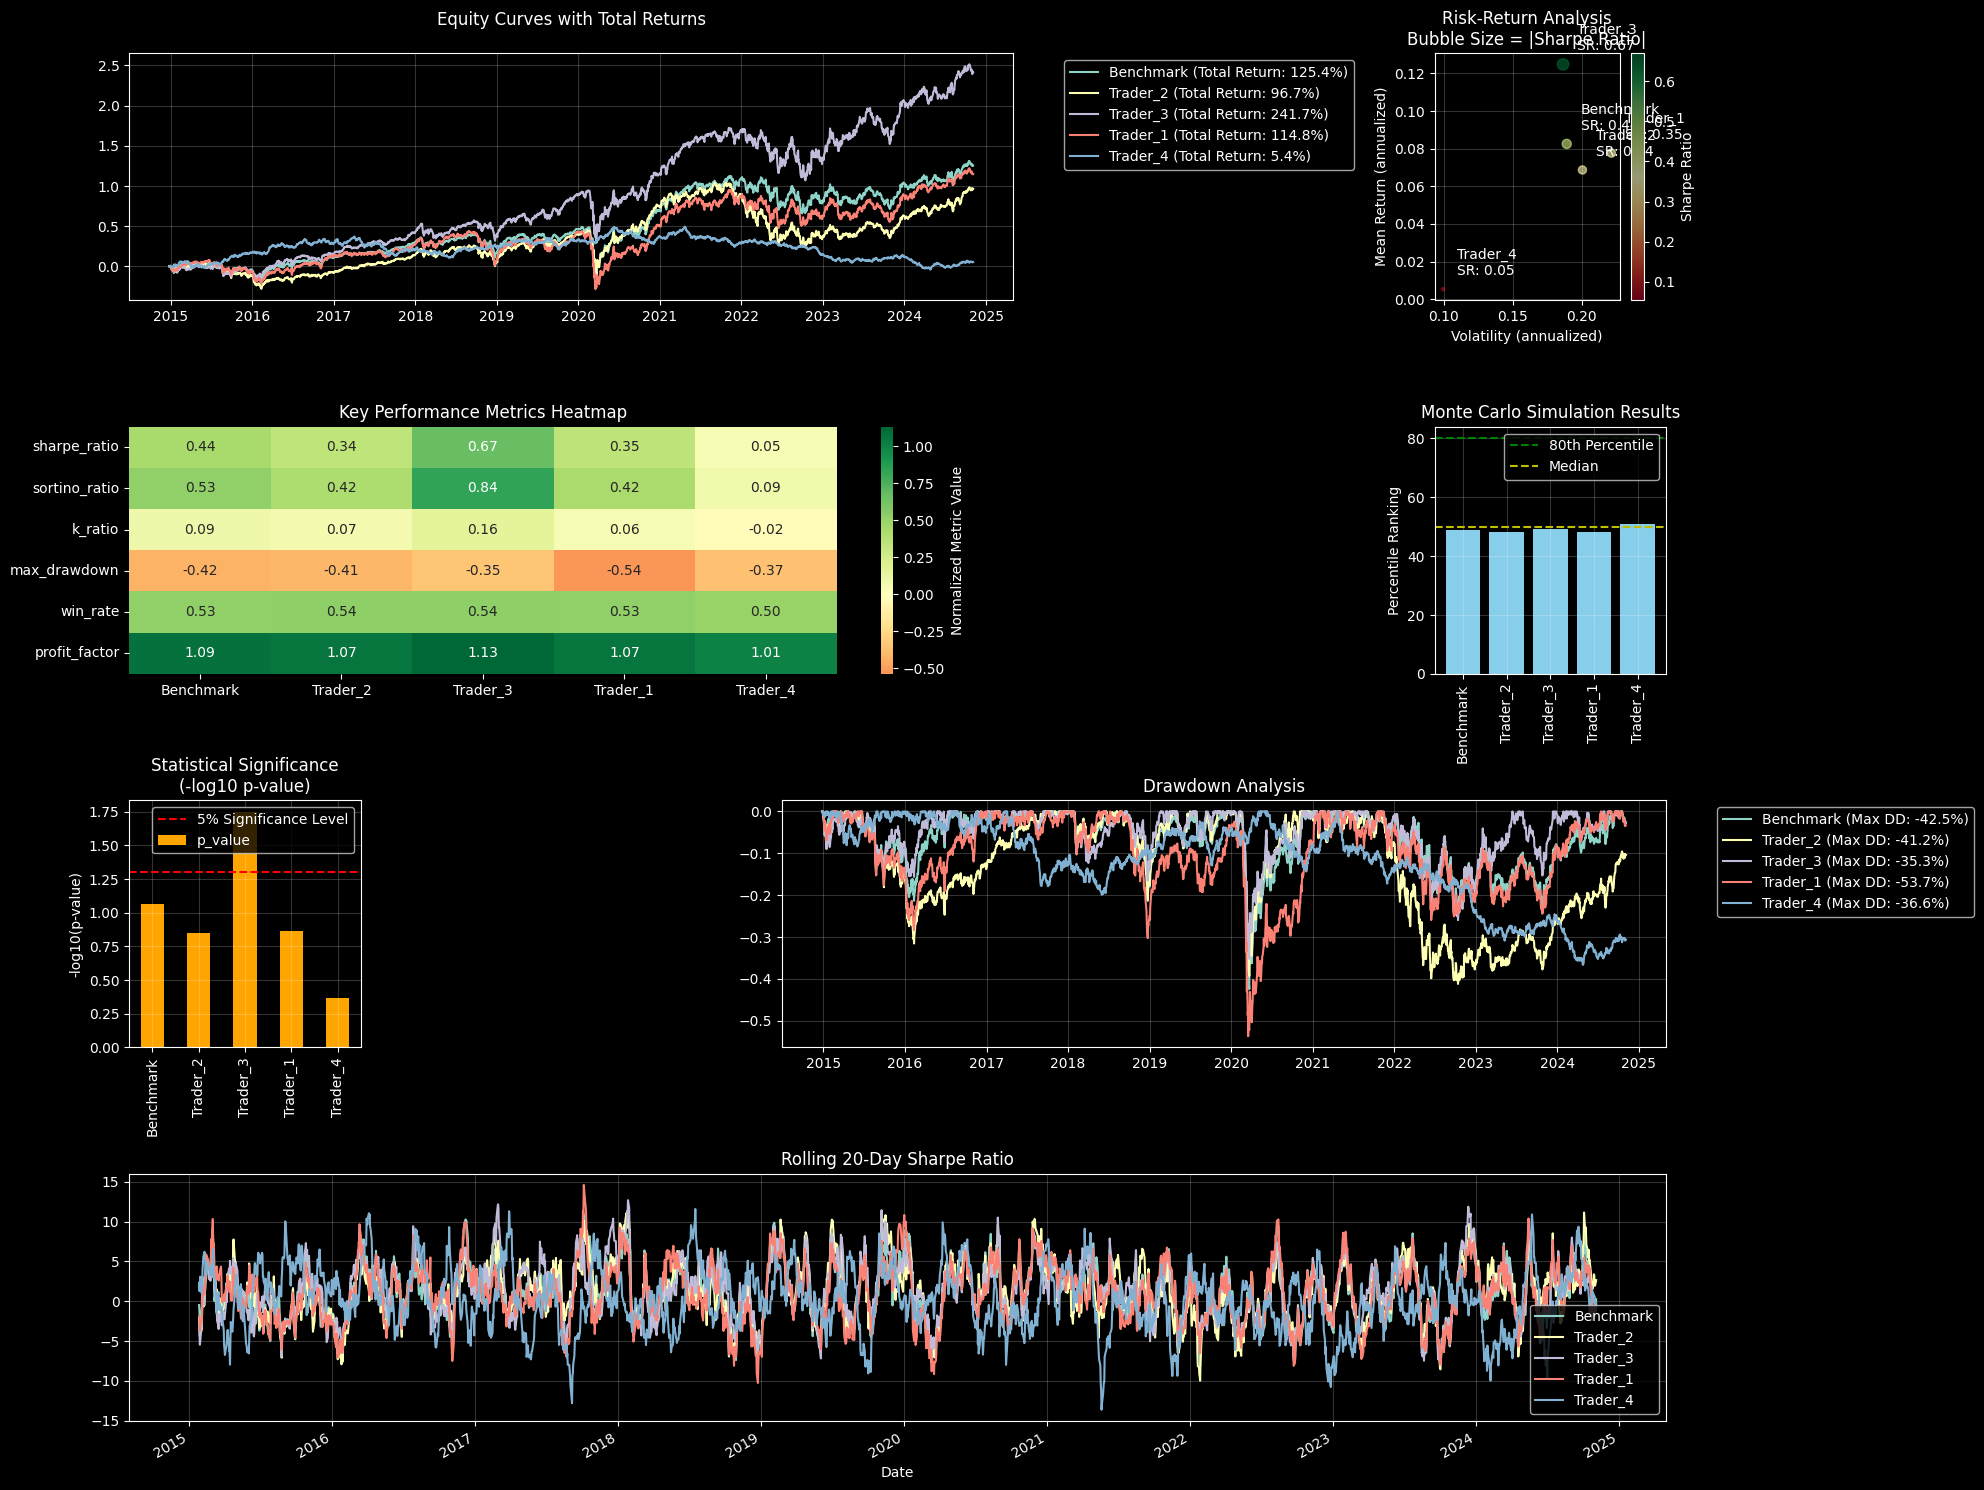

In [24]:
# If using simulated data
# returns_data = generate_trader_data(n_traders=4, n_days=252)

# If using real data (as per advisor's code)
returns_data = returns  # Already prepared in previous steps

# Create comprehensive report
report = create_comprehensive_report(returns_data)


## 12.2 Display Report Sections

* Metrics: Presents a detailed table of all calculated metrics for each trader.
* Evaluations: Provides a qualitative assessment based on predefined guidelines.
* Rankings: Shows how traders stack up against each other across key metrics.
* Visualization: Displays the comprehensive analysis plots.

In [25]:
# Display performance metrics
print("\nTrader Performance Metrics:")
print("==========================")
display(report['metrics'].round(4))

# Display trader evaluations
print("\nTrader Evaluations:")
print("==================")
for trader, evaluation in report['evaluations'].items():
    print(f"\n{trader}:")
    for metric, rating in evaluation.items():
        print(f"  {metric}: {rating}")

# Display trader rankings
print("\nTrader Rankings:")
print("================")
display(report['rankings'].round(2))

# Show visualizations
plt.show()



Trader Performance Metrics:


,Benchmark,Trader_2,Trader_3,Trader_1,Trader_4
mean_return,0.08250,0.06870,0.12480,0.07770,0.00540
volatility,0.18900,0.20040,0.18630,0.22130,0.09950
skewness,-0.77930,-0.81680,-0.52780,-1.27470,-0.09460
kurtosis,17.08150,13.49560,13.72540,19.48270,2.84700
sharpe_ratio,0.43680,0.34290,0.66980,0.35090,0.05400
sortino_ratio,0.53230,0.41830,0.83580,0.42260,0.08750
k_ratio,0.09350,0.06650,0.15890,0.05630,-0.01760
max_drawdown,-0.42450,-0.41200,-0.35250,-0.53690,-0.36650
win_rate,0.53200,0.53650,0.53890,0.53000,0.50100
profit_factor,1.08520,1.06520,1.13330,1.06700,1.00850



Trader Evaluations:

Benchmark:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor
  monte_carlo_percentile: Poor

Trader_2:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor
  monte_carlo_percentile: Poor

Trader_3:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor
  monte_carlo_percentile: Poor

Trader_1:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Acceptable
  profit_factor: Poor
  monte_carlo_percentile: Poor

Trader_4:
  sharpe_ratio: Poor
  sortino_ratio: Poor
  k_ratio: Poor
  max_drawdown: Poor
  win_rate: Poor
  profit_factor: Poor
  monte_carlo_percentile: Poor

Trader Rankings:


,sharpe_ratio,sortino_ratio,k_ratio,win_rate,profit_factor,max_drawdown,overall
Trader_3,1.00000,1.00000,1.00000,1.00000,1.00000,5.00000,1.67000
Benchmark,2.00000,2.00000,2.00000,3.00000,2.00000,2.00000,2.17000
Trader_1,3.00000,3.00000,4.00000,4.00000,3.00000,1.00000,3.00000
Trader_2,4.00000,4.00000,3.00000,2.00000,4.00000,3.00000,3.33000
Trader_4,5.00000,5.00000,5.00000,5.00000,5.00000,4.00000,4.83000


# Part 13: Additional Enhancements

## 13.1 Incorporate Sub-Period Analysis

To assess consistency over different periods, we can split the data into sub-periods.

* Evaluates whether traders' performance is consistent across different time frames.
* Method: Splits the data into equal-sized periods and calculates metrics for each period.
* Analysis: Can identify traders who perform well consistently versus those with sporadic success.

In [26]:
# Split data into sub-periods
num_periods = 5
returns_data['Period'] = pd.qcut(range(len(returns_data)), q=num_periods, labels=False)
periods = [returns_data[returns_data['Period'] == i].drop(columns='Period') for i in range(num_periods)]

# Calculate metrics for each sub-period
subperiod_metrics = {}
for i, period_returns in enumerate(periods):
    metrics = calculate_all_metrics(period_returns)
    subperiod_metrics[f'Period_{i+1}'] = metrics

# Display sub-period metrics for Sharpe Ratio
print("\nSub-Period Sharpe Ratios:")
print("==========================")
sharpe_ratios = pd.DataFrame({period: metrics.loc['sharpe_ratio'] for period, metrics in subperiod_metrics.items()})
display(sharpe_ratios)



Sub-Period Sharpe Ratios:


,Period_1,Period_2,Period_3,Period_4,Period_5
Benchmark,0.34359,0.64521,0.41723,0.39282,0.61113
Trader_2,-0.24196,0.92133,0.66802,-0.32898,1.10460
Trader_3,0.45618,1.15706,0.61756,0.39189,1.14222
Trader_1,0.30837,0.36104,0.19718,0.42103,0.73503
Trader_4,1.24891,-0.13525,0.19711,-0.28166,-0.82852


## 13.2 Plot Sub-Period Sharpe Ratios



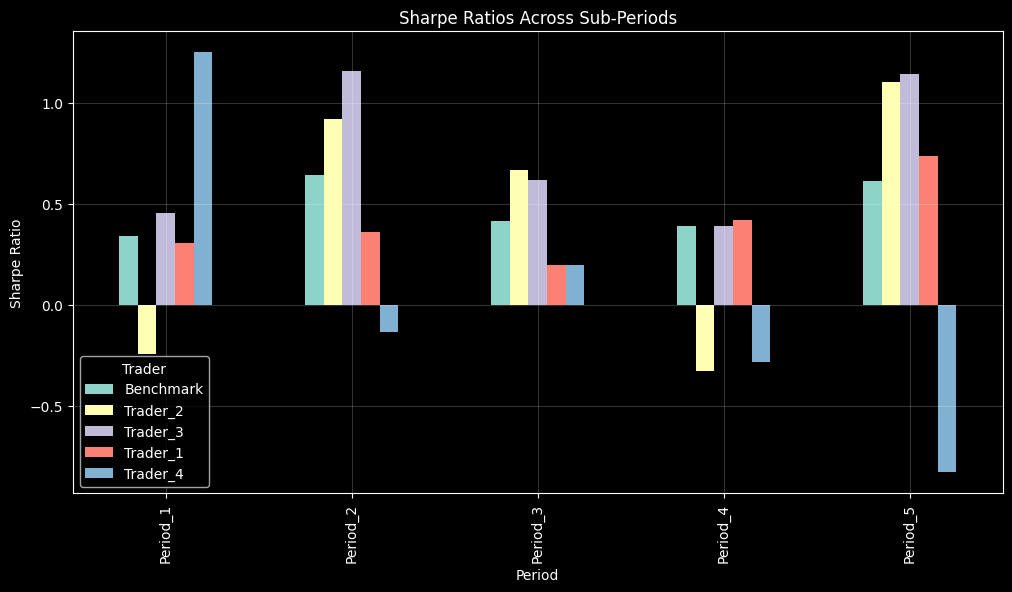

In [27]:
# Plot Sharpe Ratios across periods
sharpe_ratios.T.plot(kind='bar', figsize=(12, 6))
plt.title('Sharpe Ratios Across Sub-Periods')
plt.xlabel('Period')
plt.ylabel('Sharpe Ratio')
plt.grid(True, alpha=0.2)
plt.legend(title='Trader')
plt.show()
